In [47]:
import pandas as pd
import pandas.io.sql as pd_sql
import sqlite3 as sql
import numpy as np
from pandas import Series, DataFrame
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=8)

#scrube sanitizes database inputs by only accepting alphanumerics, i.e. A-Z a-z 0-9
#this prevents sql injection
#as a result, database and table names should only contain alphanumerics.
def scrub(db_input):
    return ''.join( chr for chr in db_input if chr.isalnum() )

In [68]:
mopexdf = pd.read_csv('/home/kecai/Downloads/r7283968out_overlap/mosaic_extract.tbl', \
                         sep = '\s+', header = None, skiprows = 70, names = ['RA', 'DEC'])
photvisdf = pd.read_csv('/home/kecai/Downloads/r7283968out_overlap/photvis_detect.list', \
                     sep = ',', header = None, names = ['RA', 'DEC'])

In [87]:
#con = sql.connect('/home/kecai/Downloads/compare.db')
con = sql.connect(':memory:')
mopexdf.to_sql("mopextb", con, if_exists = 'replace', index = False)
photvisdf.to_sql("photvistb", con, if_exists = 'replace', index = False)
con.commit()
cur = con.cursor()
cur.execute('''CREATE INDEX pv_rd ON photvistb (RA, DEC)''')
cur.execute('''CREATE INDEX mx_rd ON mopextb (RA, DEC)''')

In [88]:
def catalogue_compare_mix(df, table_name_string, margin, conn):
    D = np.empty([len(df)], dtype = float)
    i = 0
    for df_row in df.itertuples():
        min_distance = margin
        cursor = conn.cursor()
        bounds = [df_row[1] - margin, df_row[1] + margin, df_row[2] - margin, df_row[2] + margin]
        for row in cursor.execute('''SELECT * FROM ''' + scrub(table_name_string) + ''' 
                                     WHERE 
                                     RA > ? and 
                                     RA < ? and
                                     DEC > ? and
                                     DEC < ?''', bounds):
            distance = math.sqrt((df_row[1] - row[0])**2 + (df_row[2] - row[1])**2)
            if min_distance > distance:
                min_distance = distance
        if min_distance < margin:
            D[i] = min_distance
        else:
            D[i] = -0.0001
        i = i+1
    return D

In [89]:
import time

#start = time.time()
#D_df = catalogue_compare_df(mopex_df, photvis_df, 0.001)
#print time.time() - start

start = time.time()
D_mopex_photvis = catalogue_compare_mix(mopexdf, 'photvistb', 0.001, con)
print time.time() - start

start = time.time()
D_photvis_mopex = catalogue_compare_mix(photvisdf, 'mopextb', 0.001, con)
print time.time() - start

1.44619297981
1.21406602859


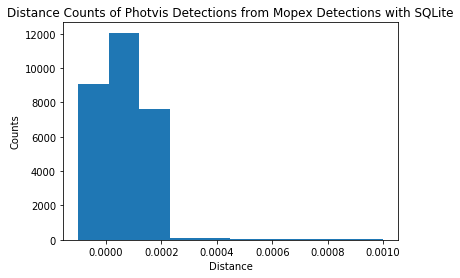

In [81]:
plt.hist(D_mopex_photvis)
plt.title("Distance Counts of Photvis Detections from Mopex Detections with SQLite")
plt.xlabel("Distance")
plt.ylabel("Counts")
plt.show()

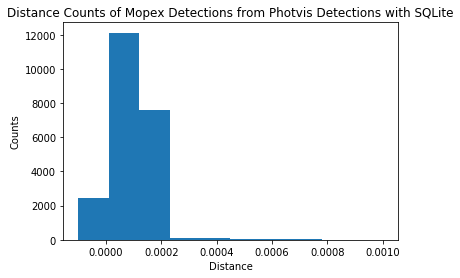

In [82]:
plt.hist(D_photvis_mopex)
plt.title("Distance Counts of Mopex Detections from Photvis Detections with SQLite")
plt.xlabel("Distance")
plt.ylabel("Counts")
plt.show()